### Imports

In [1]:
import pandas as pd
import numpy as np
import os
import glob
from pathlib import Path

In [2]:
# Path to PPG dataset folder
PPG_DATA_PATH ='./PPG Signal Dataset/data/'

In [3]:
csv_files = sorted(glob.glob(os.path.join(PPG_DATA_PATH, '*.csv')))
print(f"Found {len(csv_files)} CSV files")
csv_files[:5]  # Preview first few filenames


Found 59 CSV files


['./PPG Signal Dataset/data\\S01.csv',
 './PPG Signal Dataset/data\\S02.csv',
 './PPG Signal Dataset/data\\S03.csv',
 './PPG Signal Dataset/data\\S04.csv',
 './PPG Signal Dataset/data\\S05.csv']

In [4]:
subject_ids = []
for csv_file in csv_files:
    filename = os.path.basename(csv_file)
    subject_id = int(filename[1:3])
    subject_ids.append(subject_id)

subject_ids[:10], len(set(subject_ids))


([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 59)

In [5]:
all_data = []

for i, csv_file in enumerate(csv_files):
    df = pd.read_csv(csv_file)

    filename = os.path.basename(csv_file)
    subject_id = int(filename[1:3])

    df['subject_id'] = subject_id
    df['sample_index'] = range(len(df))

    all_data.append(df)

    if (i+1) % 10 == 0:
        print(f"Loaded {i+1}/{len(csv_files)} files...")


Loaded 10/59 files...
Loaded 20/59 files...
Loaded 30/59 files...
Loaded 40/59 files...
Loaded 50/59 files...


In [ ]:
ppg_data = pd.concat(all_data, ignore_index=True)
ppg_data.shape


(3540000, 3)

In [ ]:
print(f"\n PPG data loaded:")
print(f"  Total rows: {len(ppg_data)}")
print("-"*30)

print(f"  Unique subjects: {ppg_data['subject_id'].nunique()}")
print("-"*30)
print(ppg_data.head())



 PPG data loaded:
  Total rows: 3540000
------------------------------
  Unique subjects: 59
------------------------------
       PPG  subject_id  sample_index
0 -2015067           1             0
1 -2015050           1             1
2 -2014768           1             2
3 -2015380           1             3
4 -2015573           1             4


In [ ]:
window_size = 600   # 6 seconds at 100 Hz
step_size = 300     # 3-second step
subjects = ppg_data['subject_id'].unique()
subjects

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59])

In [ ]:
features_list = []

for subject_id in ppg_data['subject_id'].unique():
    subject_data = ppg_data[ppg_data['subject_id'] == subject_id]['PPG'].values
    
    for i in range(0, len(subject_data) - window_size, step_size):
        window = subject_data[i:i + window_size]
        
        features_list.append({
            'subject_id': subject_id,
            'window_index': i // step_size,
            'ppg_mean': np.mean(window),
            'ppg_std': np.std(window),
            'ppg_min': np.min(window),
            'ppg_max': np.max(window),
            'ppg_range': np.max(window) - np.min(window),
        })

ppg_features = pd.DataFrame(features_list)


In [15]:
print(f"Total windows: {len(ppg_features)}")
print(f"Feature columns: {ppg_features.columns.tolist()}")
ppg_features.head(1500)

Total windows: 11682
Feature columns: ['subject_id', 'window_index', 'ppg_mean', 'ppg_std', 'ppg_min', 'ppg_max', 'ppg_range']


,subject_id,window_index,ppg_mean,ppg_std,ppg_min,ppg_max,ppg_range
0,1,0,-2.017037e+06,8045.696421,-2029178,-2002055,27123
1,1,1,-2.015580e+06,8901.650078,-2029178,-2002026,27152
2,1,2,-2.016640e+06,8357.321026,-2030738,-2002026,28712
3,1,3,-2.029809e+06,7696.546385,-2045496,-2014826,30670
4,1,4,-2.033443e+06,5359.049008,-2045496,-2024199,21297
...,...,...,...,...,...,...,...
1495,8,109,-4.349333e+05,5616.221316,-444513,-422796,21717
1496,8,110,-4.298716e+05,5739.641023,-440149,-419246,20903
1497,8,111,-4.264298e+05,6787.376232,-440001,-415984,24017
1498,8,112,-4.286759e+05,7682.261238,-441449,-415984,25465


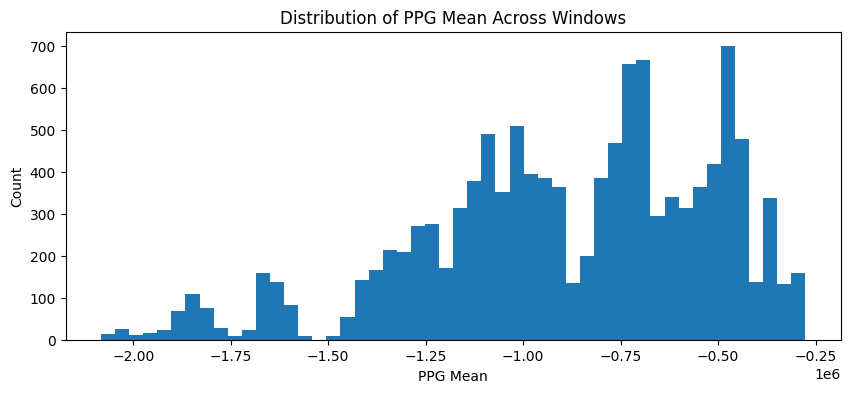

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.hist(ppg_features['ppg_mean'], bins=50)
plt.title("Distribution of PPG Mean Across Windows")
plt.xlabel("PPG Mean")
plt.ylabel("Count")
plt.show()


In [ ]:
def calculate_lf_hf(rr_intervals):
    """Calculate LF/HF ratio"""
    from scipy.signal import welch
    
    # Interpolate RR to regular 4 Hz
    time = np.cumsum(rr_intervals) / 1000
    rr_interp = np.interp(np.linspace(0, time[-1], int(time[-1] * 4)), time, rr_intervals)
    
    freq, psd = welch(rr_interp, fs=4, nperseg=min(256, len(rr_interp)))
    
    # LF: 0.04-0.15 Hz, HF: 0.15-0.4 Hz
    lf = np.trapz(psd[(freq >= 0.04) & (freq <= 0.15)])
    hf = np.trapz(psd[(freq >= 0.15) & (freq <= 0.4)])
    
    return lf / hf if hf > 0 else 0

def approximate_entropy(series, m=2, r=None):
    """Calculate approximate entropy"""
    if r is None:
        r = 0.2 * np.std(series)
    
    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])
    
    B = 0
    for i in range(len(series) - m):
        for j in range(i+1, len(series) - m):
            if _maxdist(series[i:i+m], series[j:j+m]) <= r:
                B += 1
    
    A = 0
    for i in range(len(series) - m - 1):
        for j in range(i+1, len(series) - m):
            if _maxdist(series[i:i+m+1], series[j:j+m+1]) <= r:
                A += 1
    
    return -np.log(A / B) if B > 0 else 0

def sample_entropy(series, m=2, r=None):
    """Calculate sample entropy"""
    if r is None:
        r = 0.2 * np.std(series)
    
    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])
    
    B = sum(1 for i in range(len(series)-m) for j in range(i+1, len(series)-m)
            if _maxdist(series[i:i+m], series[j:j+m]) <= r)
    
    A = sum(1 for i in range(len(series)-m-1) for j in range(i+1, len(series)-m)
            if _maxdist(series[i:i+m+1], series[j:j+m+1]) <= r)
    
    return -np.log(A / B) if B > 0 else 0

def calculate_dfa(series):
    """Detrended Fluctuation Analysis"""
    profile = np.cumsum(series - np.mean(series))
    scales = np.logspace(0.5, 2.5, 20)
    fluct = []
    
    for scale in scales:
        scale_int = int(scale)
        chunks = len(profile) // scale_int
        f = 0
        for i in range(chunks):
            chunk = profile[i*scale_int:(i+1)*scale_int]
            fit = np.polyfit(np.arange(len(chunk)), chunk, 1)
            f += np.mean((chunk - np.polyval(fit, np.arange(len(chunk))))**2)
        fluct.append(np.sqrt(f / chunks) if chunks > 0 else 0)
    
    return np.polyfit(np.log(scales), np.log(fluct), 1) if len(fluct) > 0 else 1

def calculate_sd1_sd2(rr_intervals):
    """Poincaré plot SD1/SD2 ratio"""
    x = rr_intervals[:-1]
    y = rr_intervals[1:]
    
    sd1 = np.sqrt(np.sum((x - y)**2) / (2 * len(x)))
    sd2 = np.sqrt(2 * np.sum((x + y)**2) / (4 * len(x)) - sd1**2)
    
    return sd1 / sd2 if sd2 > 0 else 0

def extract_hrv_from_ppg(ppg_signal, sampling_rate=100, window_duration=30):
    """
    Extract HRV features from PPG signal with better error handling
    """
    try:
        # Filter PPG to extract heartbeats
        sos = signal.butter(4, [0.5, 8], 'bp', fs=sampling_rate, output='sos')
        ppg_filtered = signal.sosfilt(sos, ppg_signal)
        
        # Find peaks (heartbeats)
        peaks, _ = find_peaks(ppg_filtered, distance=sampling_rate*0.4, 
                             height=np.mean(ppg_filtered))
        
        print(f"Found {len(peaks)} peaks")  # DEBUG
        
        if len(peaks) < 3:
            print(f"Too few peaks: {len(peaks)}")  # DEBUG
            return None
        
        # RR intervals in milliseconds
        rr = np.diff(peaks) / sampling_rate * 1000
        
        print(f"RR intervals: min={rr.min():.1f}, max={rr.max():.1f}, mean={rr.mean():.1f}")  # DEBUG
        
        # Basic validation
        if len(rr) < 2 or np.std(rr) == 0:
            print("Invalid RR intervals")  # DEBUG
            return None
        
        # Extract features with error handling
        features = {}
        
        try:
            features['HR_mean'] = 60000 / np.mean(rr)
            features['HR_std'] = np.std(60000 / rr) if len(rr) > 1 else 0
            features['SDNN'] = np.std(rr)
            features['RMSSD'] = np.sqrt(np.mean(np.diff(rr)**2))
            features['pNN50'] = 100 * np.sum(np.abs(np.diff(rr)) > 50) / len(rr)
        except Exception as e:
            print(f"Error in basic features: {e}")
            return None
        
        # Advanced features (wrap in try-except)
        try:
            features['LF_HF'] = calculate_lf_hf(rr)
        except:
            features['LF_HF'] = 0
            
        try:
            features['ApEn'] = approximate_entropy(rr)
        except:
            features['ApEn'] = 0
            
        try:
            features['SampEn'] = sample_entropy(rr)
        except:
            features['SampEn'] = 0
            
        try:
            dfa_result = calculate_dfa(rr)
            features['DFA_alpha'] = dfa_result[0] if isinstance(dfa_result, np.ndarray) else dfa_result
        except:
            features['DFA_alpha'] = 1
            
        try:
            features['SD1_SD2'] = calculate_sd1_sd2(rr)
        except:
            features['SD1_SD2'] = 0
        
        return features
        
    except Exception as e:
        print(f"Error in extract_hrv_from_ppg: {e}")
        return None


# ===== DEBUGGING SECTION =====
print("=" * 60)
print("DEBUGGING PPG FEATURE EXTRACTION")
print("=" * 60)

# Check your data
print(f"\n1. Data shape:")
print(f"   ppg_combined shape: {ppg_combined.shape}")
print(f"   Unique subjects: {ppg_combined['subject_id'].nunique()}")
print(f"   Columns: {ppg_combined.columns.tolist()}")

# Check first subject
first_subject = ppg_combined['subject_id'].unique()[0]
subject_data = ppg_combined[ppg_combined['subject_id'] == first_subject]['PPG'].values

print(f"\n2. First subject ({first_subject}):")
print(f"   PPG data length: {len(subject_data)}")
print(f"   PPG range: [{subject_data.min():.3f}, {subject_data.max():.3f}]")
print(f"   PPG mean: {subject_data.mean():.3f}")
print(f"   PPG std: {subject_data.std():.3f}")

# Test window extraction
window_size = 30 * 100  # 30 seconds at 100 Hz
print(f"\n3. Window settings:")
print(f"   Window size: {window_size} samples (30 seconds)")
print(f"   Expected windows: {(len(subject_data) - window_size) // (15 * 100)}")

# Test on first window
if len(subject_data) >= window_size:
    print(f"\n4. Testing first window:")
    test_window = subject_data[:window_size]
    test_features = extract_hrv_from_ppg(test_window, sampling_rate=100)
    
    if test_features is not None:
        print(f"   ✓ Successfully extracted features!")
        for k, v in test_features.items():
            print(f"     {k}: {v:.4f}")
    else:
        print(f"   ✗ Failed to extract features from first window")
else:
    print(f"\n   ✗ Data too short for even one window!")

# ===== FIX: Run feature extraction with better error handling =====
print("\n" + "=" * 60)
print("RUNNING FEATURE EXTRACTION")
print("=" * 60)

features_list = []
failed_windows = 0
successful_windows = 0

for subject_id in ppg_combined['subject_id'].unique():
    subject_data = ppg_combined[ppg_combined['subject_id'] == subject_id]['PPG'].values
    
    # Create 30-second windows
    window_size = 30 * 100  # 30 seconds at 100 Hz
    step_size = 15 * 100    # 15-second step
    
    n_windows = (len(subject_data) - window_size) // step_size
    print(f"\nSubject {subject_id}: {len(subject_data)} samples → {n_windows} windows")
    
    for i in range(0, len(subject_data) - window_size, step_size):
        window = subject_data[i:i+window_size]
        
        features = extract_hrv_from_ppg(window, sampling_rate=100)
        
        if features is not None:
            features['subject_id'] = subject_id
            features['window_index'] = i // step_size
            features_list.append(features)
            successful_windows += 1
        else:
            failed_windows += 1

print(f"\n" + "=" * 60)
print(f"RESULTS:")
print(f"  Successful windows: {successful_windows}")
print(f"  Failed windows: {failed_windows}")
print(f"  Success rate: {100*successful_windows/(successful_windows+failed_windows):.1f}%")
print("=" * 60)

# Create features dataframe
if len(features_list) > 0:
    df_features = pd.DataFrame(features_list)
    print(f"\n✓ Created dataframe with {len(df_features)} rows")
    print(f"\nFeature statistics:")
    print(df_features.describe())
    
    # Save
    df_features.to_csv('ppg_hrv_features.csv', index=False)
    print("\n✓ Saved: ppg_hrv_features.csv")
else:
    print("\n✗ ERROR: No features extracted! Check the debug output above.")